## Makemore Pt 2

This notebook implements a MLP character model to predict the next character given more characters of context

The first model implemented in makemore.ipynb only considered the previous character for context and learned to predict it. This next model based on the paper by _Bengio et al_.

1. associate with each character in the vocabulary a distributed character feature vector (a real valued vector in Rm),
2. express the joint probability function of character sequences in terms of the feature vectors
of these characters in the sequence, and
3. learn simultaneously the character feature vectors and the parameters of that probability
function.

In [107]:
from collections import deque
import random
import torch
import torch.nn.functional as F


words = open('names.txt').read().splitlines()

In [108]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

## Architecture Overview

- Inputs: N Characters * E dimensions feature vectors

E.g. if using 3 context chars and encoding each as a vector in 3 dimensional space, then each input to the NN is a 9 dimensional vector.

- Layers:

1) Embedding lookup : takes in each of N characters,outputs a feature vector for each.
2) Hidden layer 1 + tanh activation
3) Output layer 2 + softmax activation

Output:

Probability distribution of the next character given those feature vectors

In [109]:
# Utility dicts
stoi = {c:i+1 for i,c in enumerate(sorted(set("".join(words))))}
stoi["."] = 0
itos = {i:c for c,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [110]:
# Create the dataset
CONTEXT_WINDOW = 3
def build_dataset(wds):
    X,Y = [],[]
    for w in wds:
        window = deque([0]*3,maxlen=CONTEXT_WINDOW)
        for c in w + ".":
            ix = stoi[c]
            X.append(window)
            Y.append(ix)
            window.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [111]:
# Define the embedding mapping, takes in a in one hot encoding w 27 classes -> outputs vector in Rn
N = 2
C = torch.randn((27,N))

To get the embeddings we just index C with our

In [112]:
Xtr

tensor([[14,  7,  0],
        [14,  7,  0],
        [14,  7,  0],
        ...,
        [ 1, 14,  0],
        [ 1, 14,  0],
        [ 1, 14,  0]])

In [113]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 2])

### Hidden layer 1

In [114]:
# Multiple ways to make the inputs 2d
# torch.cat([emb[:, 0, :],emb[:, 1, :], emb[:, 2, :]],dim=1)
# torch.cat(torch.unbind(emb,dim = 1), dim=1)
emb.view(-1,N*3)


tensor([[-1.1994,  1.1861, -2.5050,  0.2803,  1.9098, -0.0705],
        [-1.1994,  1.1861, -2.5050,  0.2803,  1.9098, -0.0705],
        [-1.1994,  1.1861, -2.5050,  0.2803,  1.9098, -0.0705],
        ...,
        [-0.4818, -0.3282, -1.1994,  1.1861,  1.9098, -0.0705],
        [-0.4818, -0.3282, -1.1994,  1.1861,  1.9098, -0.0705],
        [-0.4818, -0.3282, -1.1994,  1.1861,  1.9098, -0.0705]])

In [115]:
W1 =  torch.randn((N*CONTEXT_WINDOW,300))
b1 = torch.randn(300)
(W1.shape,b1.shape)

(torch.Size([6, 300]), torch.Size([300]))

In [116]:
# Pass through 100 neuron hidden layer
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)

In [117]:
h

tensor([[ 0.8993,  0.9757, -0.4980,  ..., -1.0000,  0.9999, -0.9933],
        [ 0.8993,  0.9757, -0.4980,  ..., -1.0000,  0.9999, -0.9933],
        [ 0.8993,  0.9757, -0.4980,  ..., -1.0000,  0.9999, -0.9933],
        ...,
        [ 0.8704,  0.8023,  0.9868,  ..., -0.9916,  0.5271, -0.9264],
        [ 0.8704,  0.8023,  0.9868,  ..., -0.9916,  0.5271, -0.9264],
        [ 0.8704,  0.8023,  0.9868,  ..., -0.9916,  0.5271, -0.9264]])

### Output layer

In [118]:
W2 = torch.randn((300,27))
b2 = torch.randn(27)

In [119]:
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# prob.shape

In [120]:
# loss = -prob[torch.arange(100), Ytr[:100]].log().mean()
# loss

In [121]:
# cross_entropy takes the unnormalized logits then works out the cross-entropy loss, we don't need to normalize ourselves, which is inefficient
F.cross_entropy(logits, Ytr)

tensor(26.4472)

In [122]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [123]:
# Num parameters
sum(p.nelement() for p in parameters)

10281

### Training loop

Training set: used to train
Dev/validation: used to train/tune hyperparameters
Test: used to test

Notes:

- If training dataset contains far fewer examples than the number of parameters, the model will overfit the training set and show very low loss, does not mean the model is good (it won't generalise)
- While we could iterate on full dataset (forward + backward), this is inefficient and not done in practice -> use random mini-batches of the data which makes the forward/backward pass far more efficient

In [124]:
# Generate learning rates to try
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [125]:
losses = []
for i in range(1000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #Only forward + backward the mini batch
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data -= p.grad * lr
    losses.append(loss.item())
    print(loss.item())



26.808963775634766
29.916574478149414
26.166440963745117
24.001375198364258
26.560888290405273
23.66046714782715
23.82390594482422
25.042139053344727
28.84246253967285
24.943363189697266
23.330425262451172
27.47858238220215
28.579811096191406
23.09214973449707
24.880390167236328
23.8369197845459
28.353954315185547
22.59700584411621
26.773618698120117
27.48244857788086
25.133018493652344
25.95330810546875
24.73215103149414
22.76925277709961
26.752086639404297
21.40106773376465
27.917390823364258
20.90157127380371
22.079303741455078
21.662004470825195
23.928462982177734
20.420875549316406
24.513221740722656
24.03702735900879
21.40825080871582
22.700008392333984
22.902097702026367
23.660587310791016
24.450716018676758
21.326215744018555
19.310626983642578
20.994352340698242
28.41863250732422
22.131561279296875
21.766517639160156
18.11626625061035
23.032182693481445
20.73688316345215
21.88597869873047
15.432424545288086
20.10643196105957
24.2666072845459
22.471464157104492
21.1613540649414

Finding the optimal learning rate (tuning)

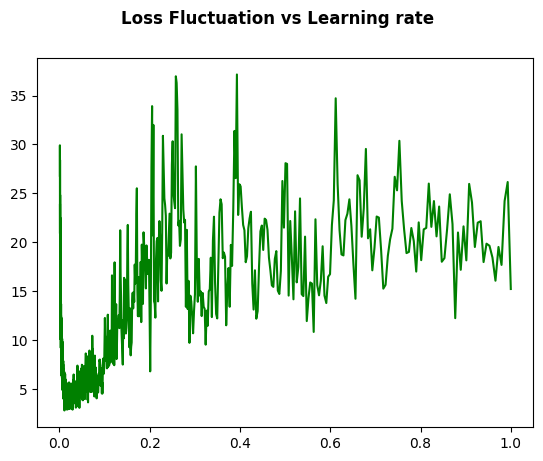

In [126]:
import matplotlib.pyplot as plt

plt.plot(lrs, losses, "g" )
plt.suptitle("Loss Fluctuation vs Learning rate", fontweight='bold')
plt.show()

From the graph we see the loss destabilizes with laearning rates >= to 0.15.

Thus we can infer suitable learning rates are around 0.1.

Best way to train is to start around 0.1 then learn the finer details with smaller lr around 0.01

In [144]:
for i in range(30000):
    # Forward pass
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #Only forward + backward the mini batch
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.03 if i < 10000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr
    losses.append(loss.item())
    print(loss.item())


2.8725221157073975
2.825213670730591
2.696415901184082
2.745191812515259
2.5594043731689453
2.7161338329315186
2.9013476371765137
2.5929551124572754
2.549992084503174
2.9774978160858154
2.6607439517974854
2.340423822402954
2.7255160808563232
3.00825834274292
2.945357322692871
2.8036584854125977
2.8536312580108643
2.8301451206207275
2.785590887069702
2.8273088932037354
2.541200637817383
2.6666672229766846
2.536632537841797
2.7016923427581787
2.4491653442382812
2.6981472969055176
2.6733148097991943
2.5910229682922363
2.7250726222991943
2.8848519325256348
2.5831401348114014
2.932634115219116
2.6206533908843994
2.3629326820373535
3.019491672515869
2.4425196647644043
2.6434619426727295
2.512928009033203
2.50500750541687
2.5216124057769775
2.544910192489624
3.062303066253662
2.8042044639587402
2.4938716888427734
2.873802661895752
2.5448343753814697
3.100281000137329
2.6922380924224854
2.517286777496338
2.6137430667877197
2.5799474716186523
2.7759227752685547
2.3729116916656494
2.652723550796

after training on the training set we look at the train/dev set loss

In [145]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

In [146]:
loss

tensor(2.6078, grad_fn=<NllLossBackward0>)

In [147]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,N*CONTEXT_WINDOW) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

In [148]:
loss

tensor(2.6311, grad_fn=<NllLossBackward0>)

In [149]:
C

tensor([[-1.6061, -0.1582],
        [-2.5144, -5.1793],
        [ 1.4267, -1.7558],
        [ 3.4138, -0.2046],
        [ 2.3475,  2.0177],
        [-3.3840,  3.8309],
        [ 1.1711,  0.7304],
        [-1.5294,  0.7531],
        [-2.0404,  1.1927],
        [ 3.7919, -0.5010],
        [-1.4346,  1.1671],
        [-1.8915,  0.8360],
        [-4.6583, -1.5853],
        [ 1.8011,  1.5147],
        [ 1.9242, -4.0352],
        [-1.6869,  0.9066],
        [-1.6703,  0.9333],
        [-1.3862,  1.0078],
        [ 1.5096,  0.8516],
        [-0.4269, -2.9261],
        [-1.7208,  1.1887],
        [ 1.2896,  0.6755],
        [ 1.3468,  0.4112],
        [ 1.1084,  0.9506],
        [-0.8770,  0.7044],
        [ 1.9599, -1.6203],
        [-0.1252, -1.2119]], requires_grad=True)

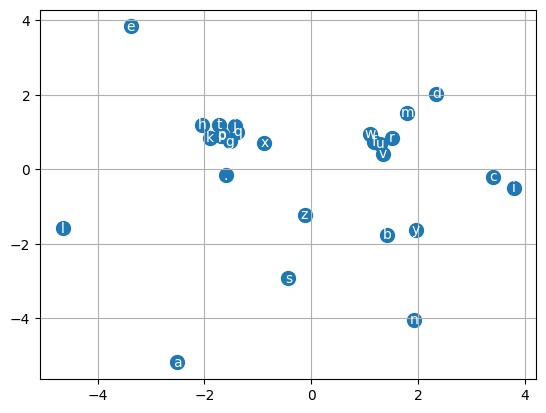

In [150]:
plt.scatter(C[:,0].data,C[:,1].data, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')